In [50]:
import numpy as np
# we have 3d analysis
languages = ['en', 'de', 'cs']
    # ("unigram_js_divergence", create_unigram_js_divergence(data), 'text'), #done
    # ("bigram_js_divergence", create_bigram_js_divergence(data), 'text'),#17648
    # ("gpt2_perplexity", create_gpt2_perplexity(), 'text'), # done
    # ("gpt2_tokens_per_char", create_bpe_tokens_per_char(), 'text'), # done
    # ("pos_js_divergence", create_pos_js_divergence(data),'original_text'), #17650
    # ("pos_bigram_js_divergence", create_pos_bigram_js_divergence(data), 'original_text'), #17655
    # ("depth_of_parse_tree", create_depth_of_parse_tree(), 'original_text'),#17652
    # ("named_entities", create_named_entities(),'original_text')#17649
features = ['unigram_js_divergence', 'bigram_js_divergence', 'gpt2_perplexity', 'gpt2_tokens_per_char', 'pos_js_divergence', 'pos_bigram_js_divergence', 'depth_of_parse_tree', 'named_entities']

slurm_ids_en = [18204, 18209, 18207, 18206, 18223, 18224, 18221, 18222]

# For German (de)
slurm_ids_de = [18303, 18305, None, 18304, 18322, 18325, 18306, 18307]

# For Czech (cs)
slurm_ids_cs = [18533, 18486, 18531, 18532, 18483, 18482, 18485, 18484]


def extract_data(name,slurm_id):
    if slurm_id is None:
        return None
    col_validate = f"eval_column: {name}"

    # check name is in 
    with open(f"slurm-{slurm_id}.out") as f:
        data = f.readlines()
    if not col_validate in "".join(data[:20]):
        raise ValueError(f"{name} not evaluated in slurm-{slurm_id}.out")

    datarow = data[-6] 
    assert datarow.startswith("Raw data: ")
    datarow = datarow[len("Raw data: "):]
    datarow = datarow.strip()
    # datarow is in the format of {1: [1,2,3], 2: [1,2,3], ...}
    # load it
    return eval(datarow)

all_data = {}
for lang in languages:
    all_data[lang] = {}
    for feature in features:
        all_data[lang][feature] = extract_data(feature, eval(f"slurm_ids_{lang}")[features.index(feature)])

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def plot_and_analyze(averages, medians, feature_name):
    """
    Plots a line chart for the given data (averages and medians) and calculates the Pearson correlation coefficient.

    Parameters:
    averages (dict): Dictionary with percentiles as keys and average error counts as values.
    medians (dict): Dictionary with percentiles as keys and median error counts as values.
    feature_name (str): Name of the feature for labeling the plot.
    """
    # Extracting percentiles and errors for averages and medians
    percentiles_avg = list(averages.keys())
    errors_avg = list(averages.values())

    percentiles_med = list(medians.keys())
    errors_med = list(medians.values())

    # Calculating Pearson Correlation Coefficient for averages and medians
    r_value_avg, _ = pearsonr(percentiles_avg, errors_avg)
    r_value_med, _ = pearsonr(percentiles_med, errors_med)

    # Creating the line chart
    plt.figure(figsize=(10, 6))
    plt.plot(percentiles_avg, errors_avg, marker='o', label=f'{feature_name} Averages')
    plt.plot(percentiles_med, errors_med, marker='x', label=f'{feature_name} Medians')
    plt.title(f'{feature_name} - Averages vs Medians')
    plt.xlabel('Percentiles')
    plt.ylabel('Error Counts')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f'Pearson correlation coefficient for {feature_name} Averages: {r_value_avg:.3f}')
    print(f'Pearson correlation coefficient for {feature_name} Medians: {r_value_med:.3f}')

In [52]:
def calculate_statistics(data):
    averages = {k: np.mean(v) for k, v in data.items()}
    stdev = {k: np.std(v) for k, v in data.items()}
    medians = {k: np.median(v) for k, v in data.items()}
    return averages, stdev, medians

In [53]:
import matplotlib.pyplot as plt

def plot_error_bars(averages, stdev, label, title, xlabel, ylabel):
    plt.errorbar(list(averages.keys()), list(averages.values()), yerr=list(stdev.values()), label=label, fmt='-o', capsize=5, ecolor='red', elinewidth=2, capthick=2, color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

In [54]:
def plot_scatter_per_language(data_dict):
    percentiles = list(data_dict.values())[0].keys()
    num_languages = len(data_dict)
    plt.figure(figsize=(12, 4 * num_languages))

    for i, (lang, percentile_data) in enumerate(data_dict.items(), start=1):
        plt.subplot(num_languages, 1, i)
        for percentile in percentiles:
            values = percentile_data.get(percentile, [])
            plt.scatter([percentile] * len(values), values, alpha=0.5, label=f'{percentile}th percentile')

        plt.title(f'Scatter Plot for {lang.upper()} Language')
        plt.xlabel('Percentile')
        plt.ylabel('Error Counts')
        # plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [55]:

def plot_medians(medians, labels, title):
    plt.figure(figsize=(10, 6))
    for i in range(len(medians)):
        plt.plot(list(medians[i].keys()), list(medians[i].values()), marker='o', label=labels[i])
    plt.title(title)
    plt.xlabel('Percentiles')
    plt.ylabel('Error Counts')
    plt.grid(True)
    plt.legend()
    plt.show()

def calculate_corrs(averages, medians):
    # Calculating Pearson Correlation Coefficient for averages and medians
    r_value_avg, _ = pearsonr(list(averages.keys()), list(averages.values()))
    r_value_med, _ = pearsonr(list(medians.keys()), list(medians.values()))
    return r_value_avg, r_value_med

In [56]:
import pandas as pd
import seaborn as sns
def plot_individual_violins(data_dict):
    percentiles = list(data_dict.values())[0].keys()
    num_languages = len(data_dict)
    plt.figure(figsize=(12, 6 * num_languages))
    palette = sns.color_palette("hsv", len(percentiles))


    for i, (lang, percentile_data) in enumerate(data_dict.items(), start=1):
        plt.subplot(num_languages, 1, i)
        df_list = []
        for percentile, values in percentile_data.items():
            for value in values:
                df_list.append({'Percentile': percentile, 'Error Count': value})
        df = pd.DataFrame(df_list)

        sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
        plt.title(f'Violin Plot of Error Counts for {lang.upper()} Language')
        plt.ylabel('Error Counts')

    plt.tight_layout()
    plt.show()


In [57]:
def analyze_feature(all_data, feature, languages):
    """
    Analyzes the given feature by calculating statistics, plotting error bars, medians, correlations, and violin plots.

    Parameters:
    feature (str): Name of the feature to analyze.
    languages (list): List of languages to analyze.
    """
    medians_data = {}
    error_bars_data = {}
    r_values_avg = {}
    r_values_med = {}

    for lang in languages:
        # Calculate statistics for the language
        averages, stdev, medians = calculate_statistics(all_data[lang][feature])

        # Store data for plotting
        error_bars_data[lang] = (averages, stdev)
        medians_data[lang] = medians

        # Calculate correlations for the language
        r_value_avg, r_value_med = calculate_corrs(averages, medians)
        r_values_avg[lang] = r_value_avg
        r_values_med[lang] = r_value_med

    # Plot error bars for all languages
    for lang in languages:
        averages, stdev = error_bars_data[lang]
        plot_error_bars(averages, stdev, lang, feature, 'Percentiles', 'Error Counts')

    # Print correlations for all languages
    for lang in languages:
        print(f"{lang} pearson r for averages: {r_values_avg[lang]}, {lang} pearson r for medians: {r_values_med[lang]}")

    # Plot medians for all languages
    plot_medians(list(medians_data.values()), languages, f"{feature} - Medians")

    # Plot violin plots for all languages but only this feature such as
    plot_individual_violins({lang: all_data[lang][feature] for lang in languages})


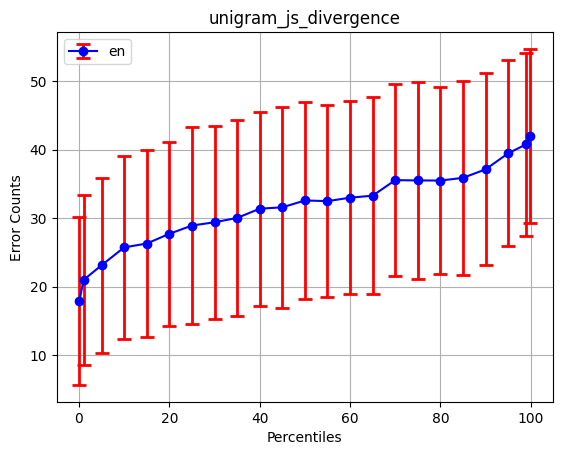

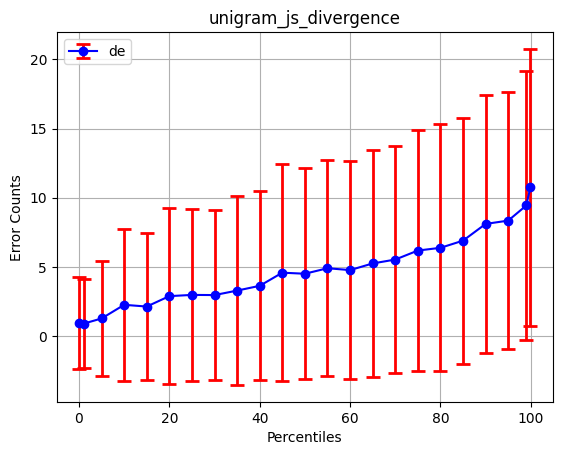

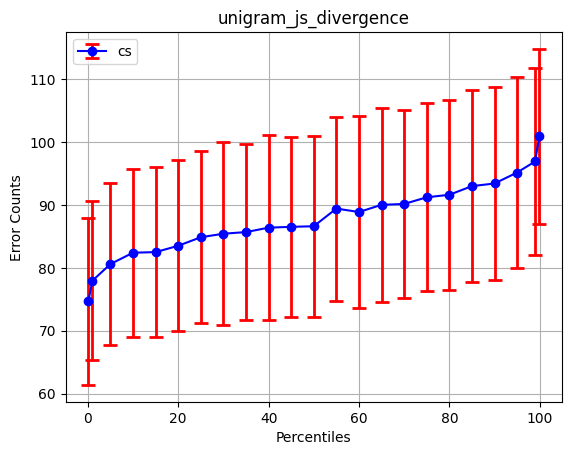

en pearson r for averages: 0.9664659136060147, en pearson r for medians: 0.975579137499152
de pearson r for averages: 0.9712434400701669, de pearson r for medians: 0.5956241772680335
cs pearson r for averages: 0.9640227607481758, cs pearson r for medians: 0.9574250648134833


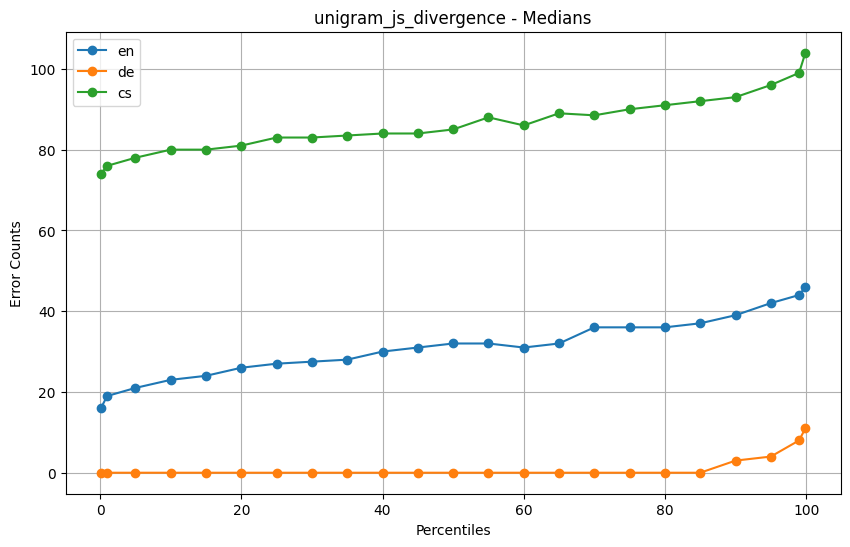

/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)


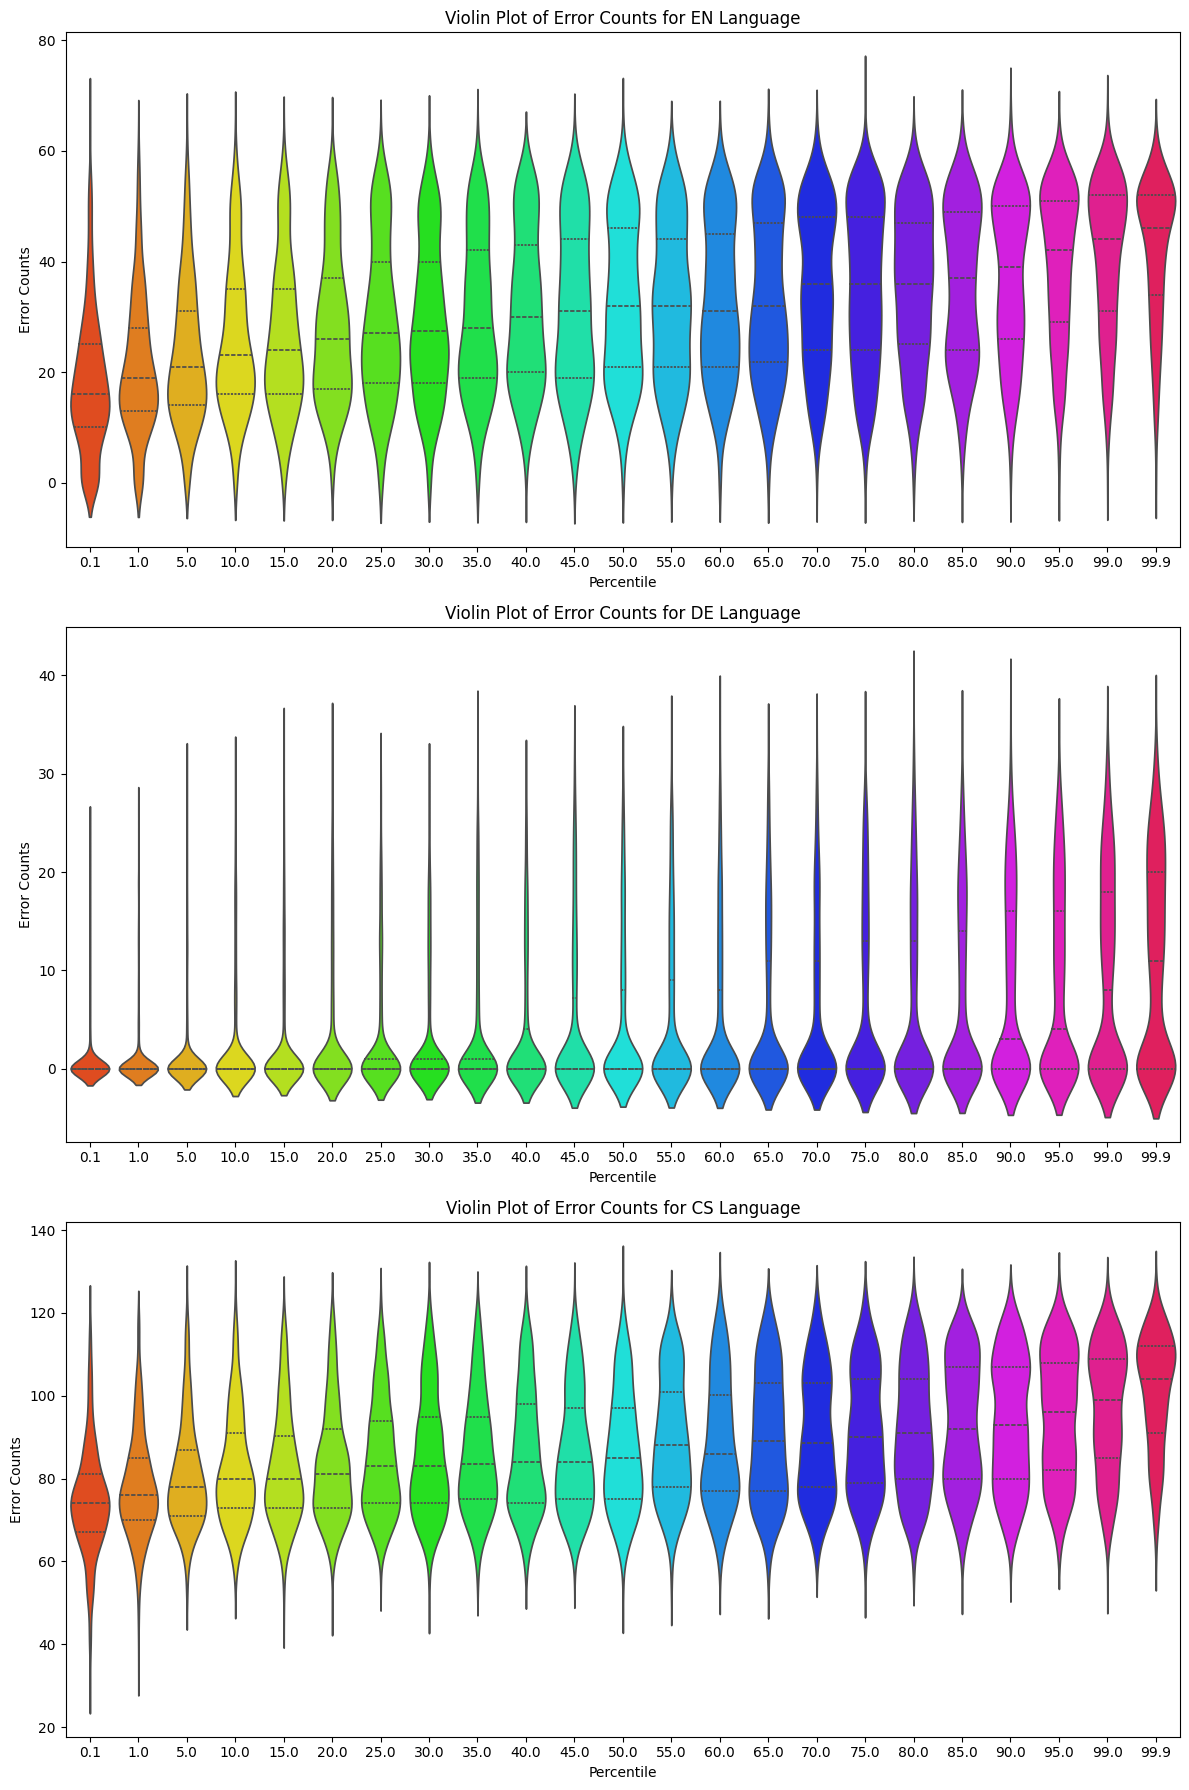

In [58]:
analyze_feature(all_data,'unigram_js_divergence', languages)

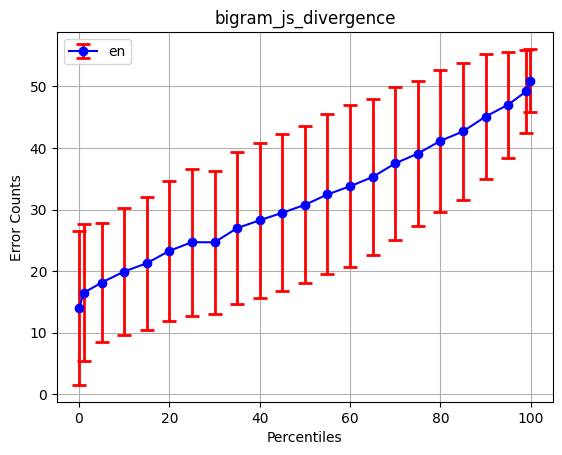

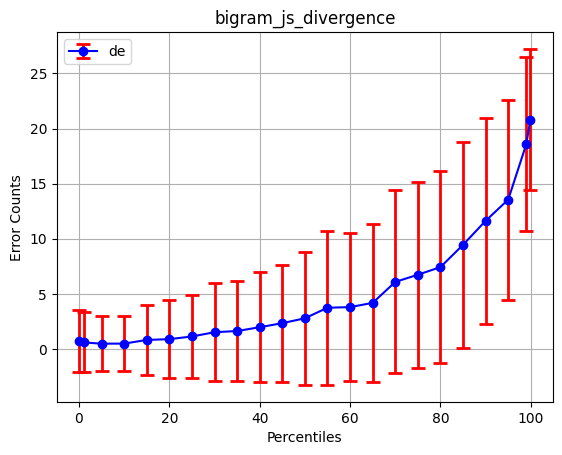

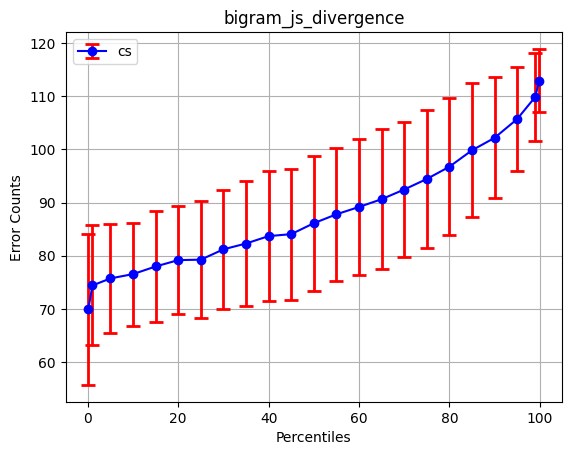

en pearson r for averages: 0.9946506528861041, en pearson r for medians: 0.9945259356298957
de pearson r for averages: 0.8707146375476081, de pearson r for medians: 0.7215300027339951
cs pearson r for averages: 0.9737506835506888, cs pearson r for medians: 0.9679095462550954


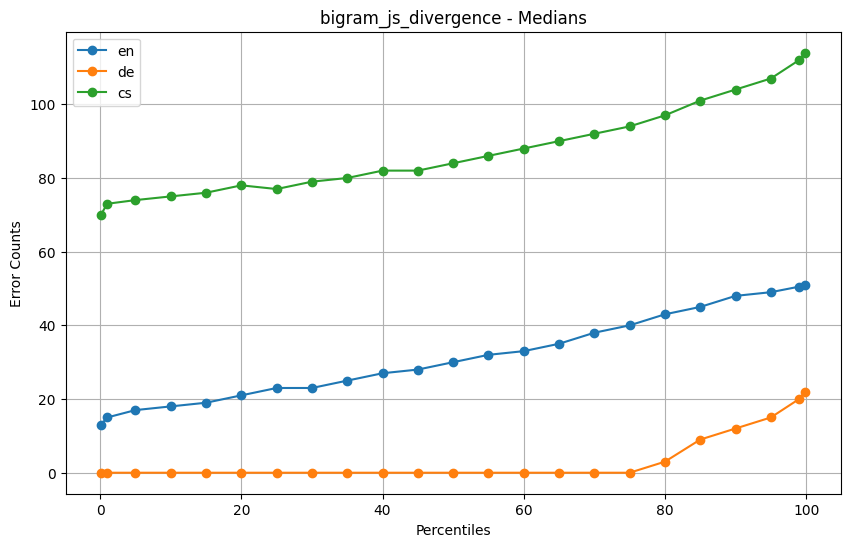

/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)


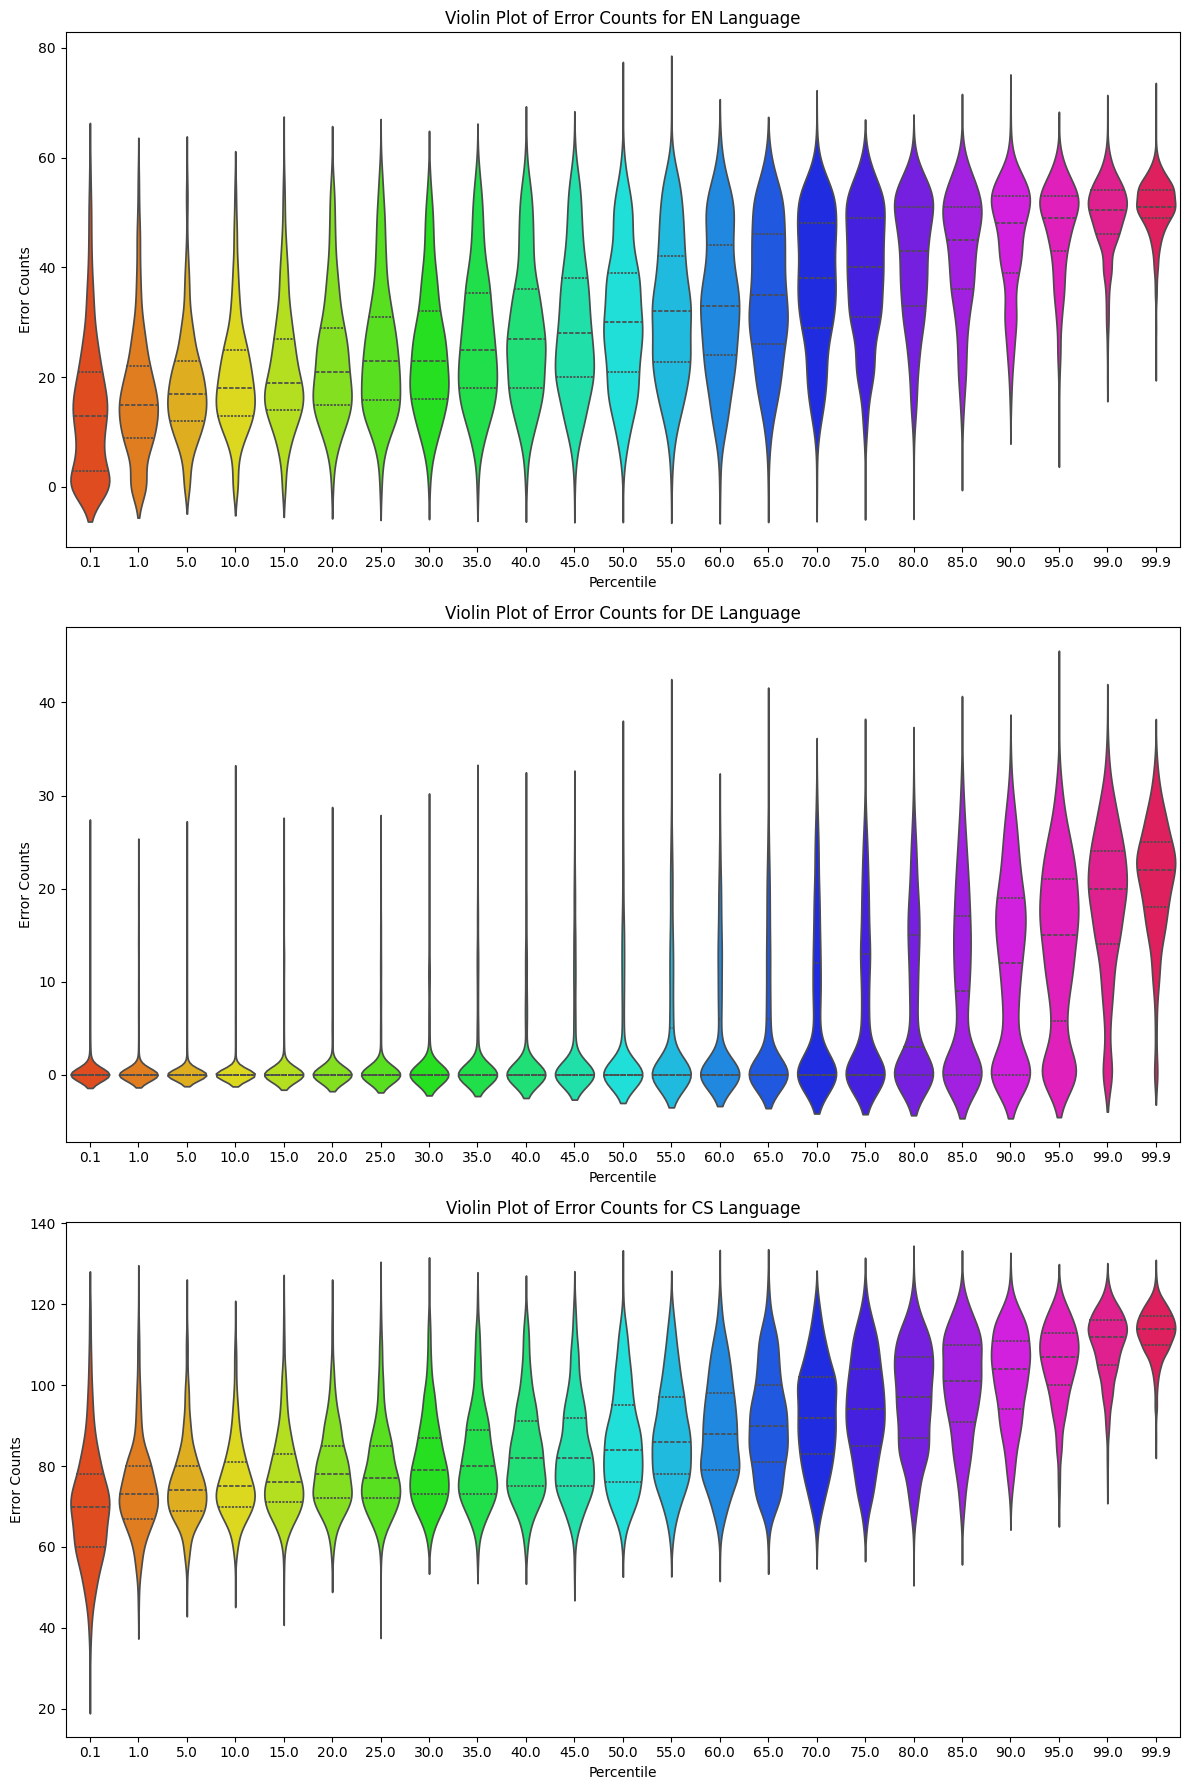

In [59]:

# - **eval_column: bigram_js_divergence**
analyze_feature(all_data,'bigram_js_divergence', languages)

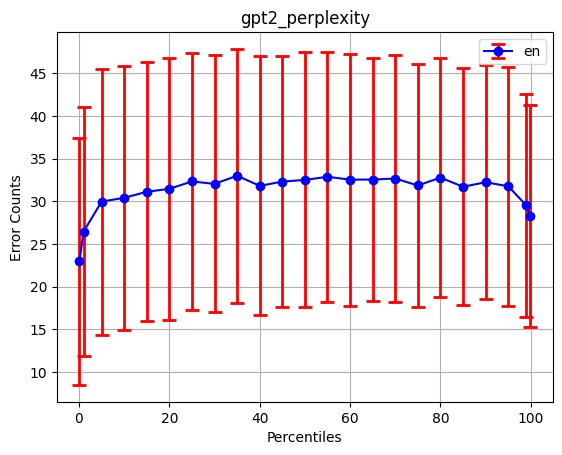

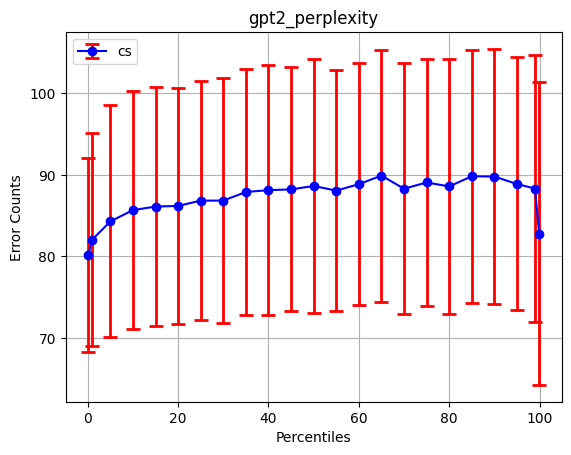

en pearson r for averages: 0.36577590593946796, en pearson r for medians: 0.3705575932180688
cs pearson r for averages: 0.6004444562702573, cs pearson r for medians: 0.6809222169979557


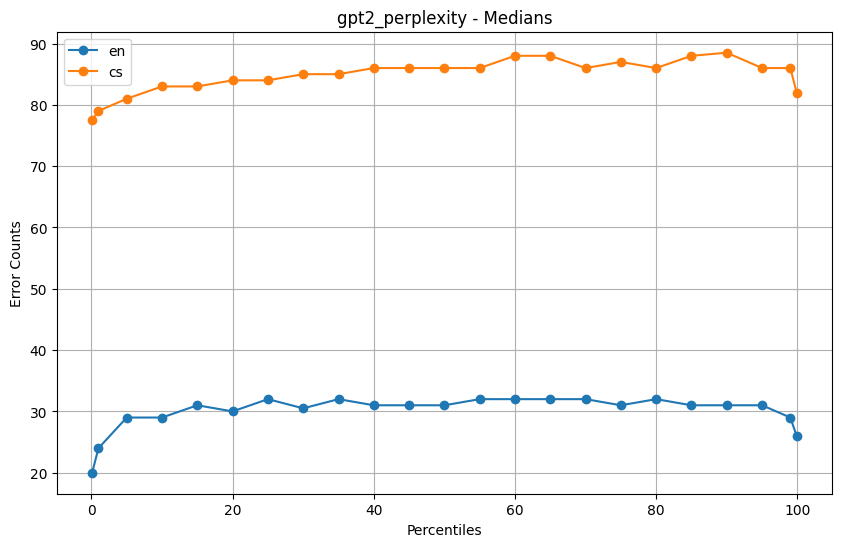

/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)


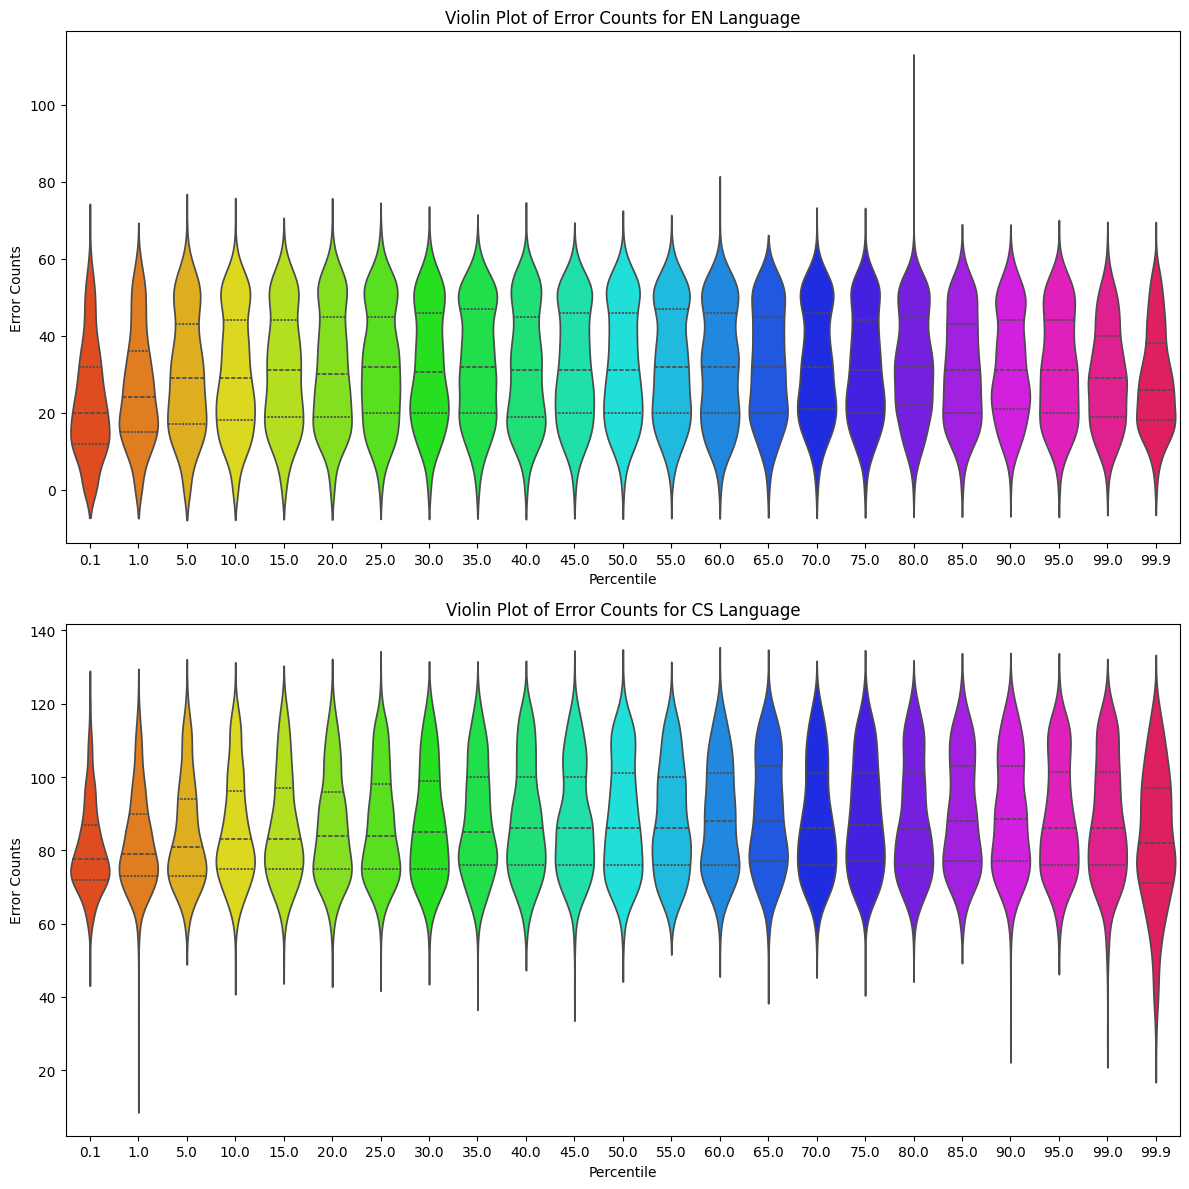

In [60]:
# - **eval_column: gpt2_perplexity**
analyze_feature(all_data,'gpt2_perplexity', ['en','cs'])

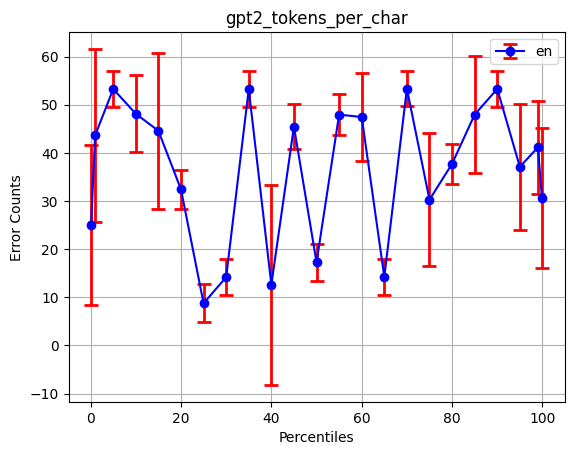

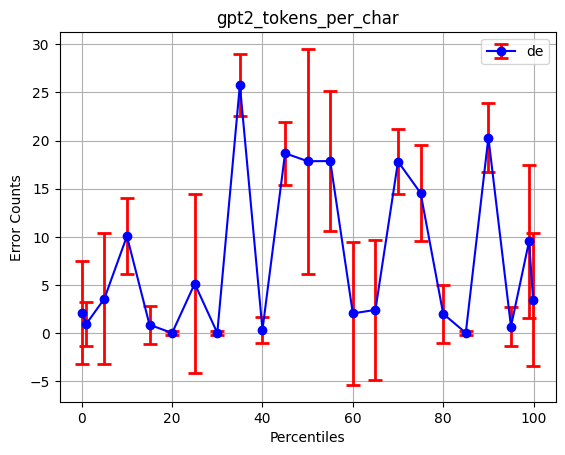

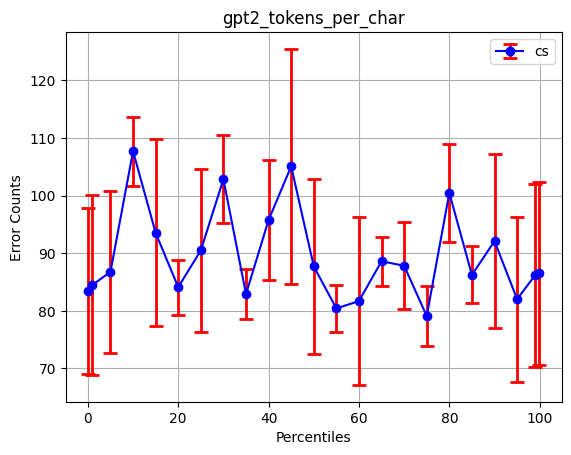

en pearson r for averages: 0.09448509993733183, en pearson r for medians: 0.0633600758172002
de pearson r for averages: 0.17456650001707652, de pearson r for medians: 0.16643844401570393
cs pearson r for averages: -0.1929111537703891, cs pearson r for medians: -0.15494661015987996


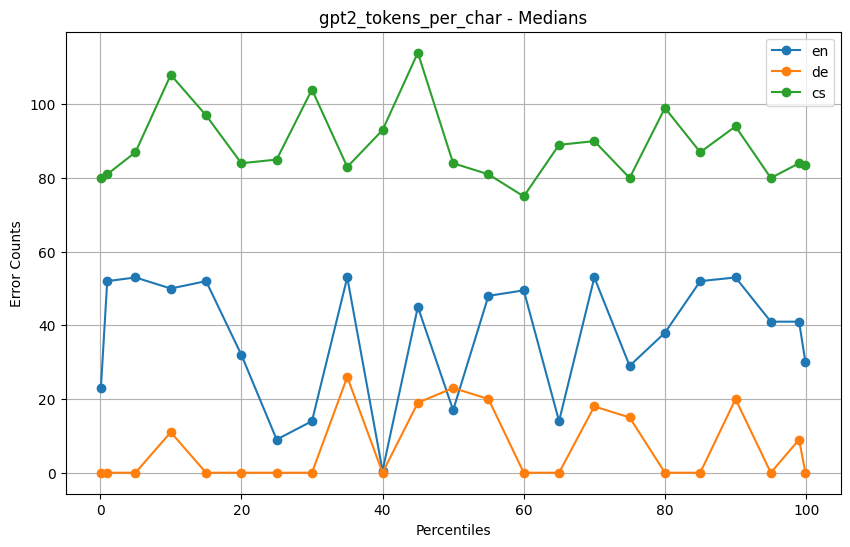

/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)


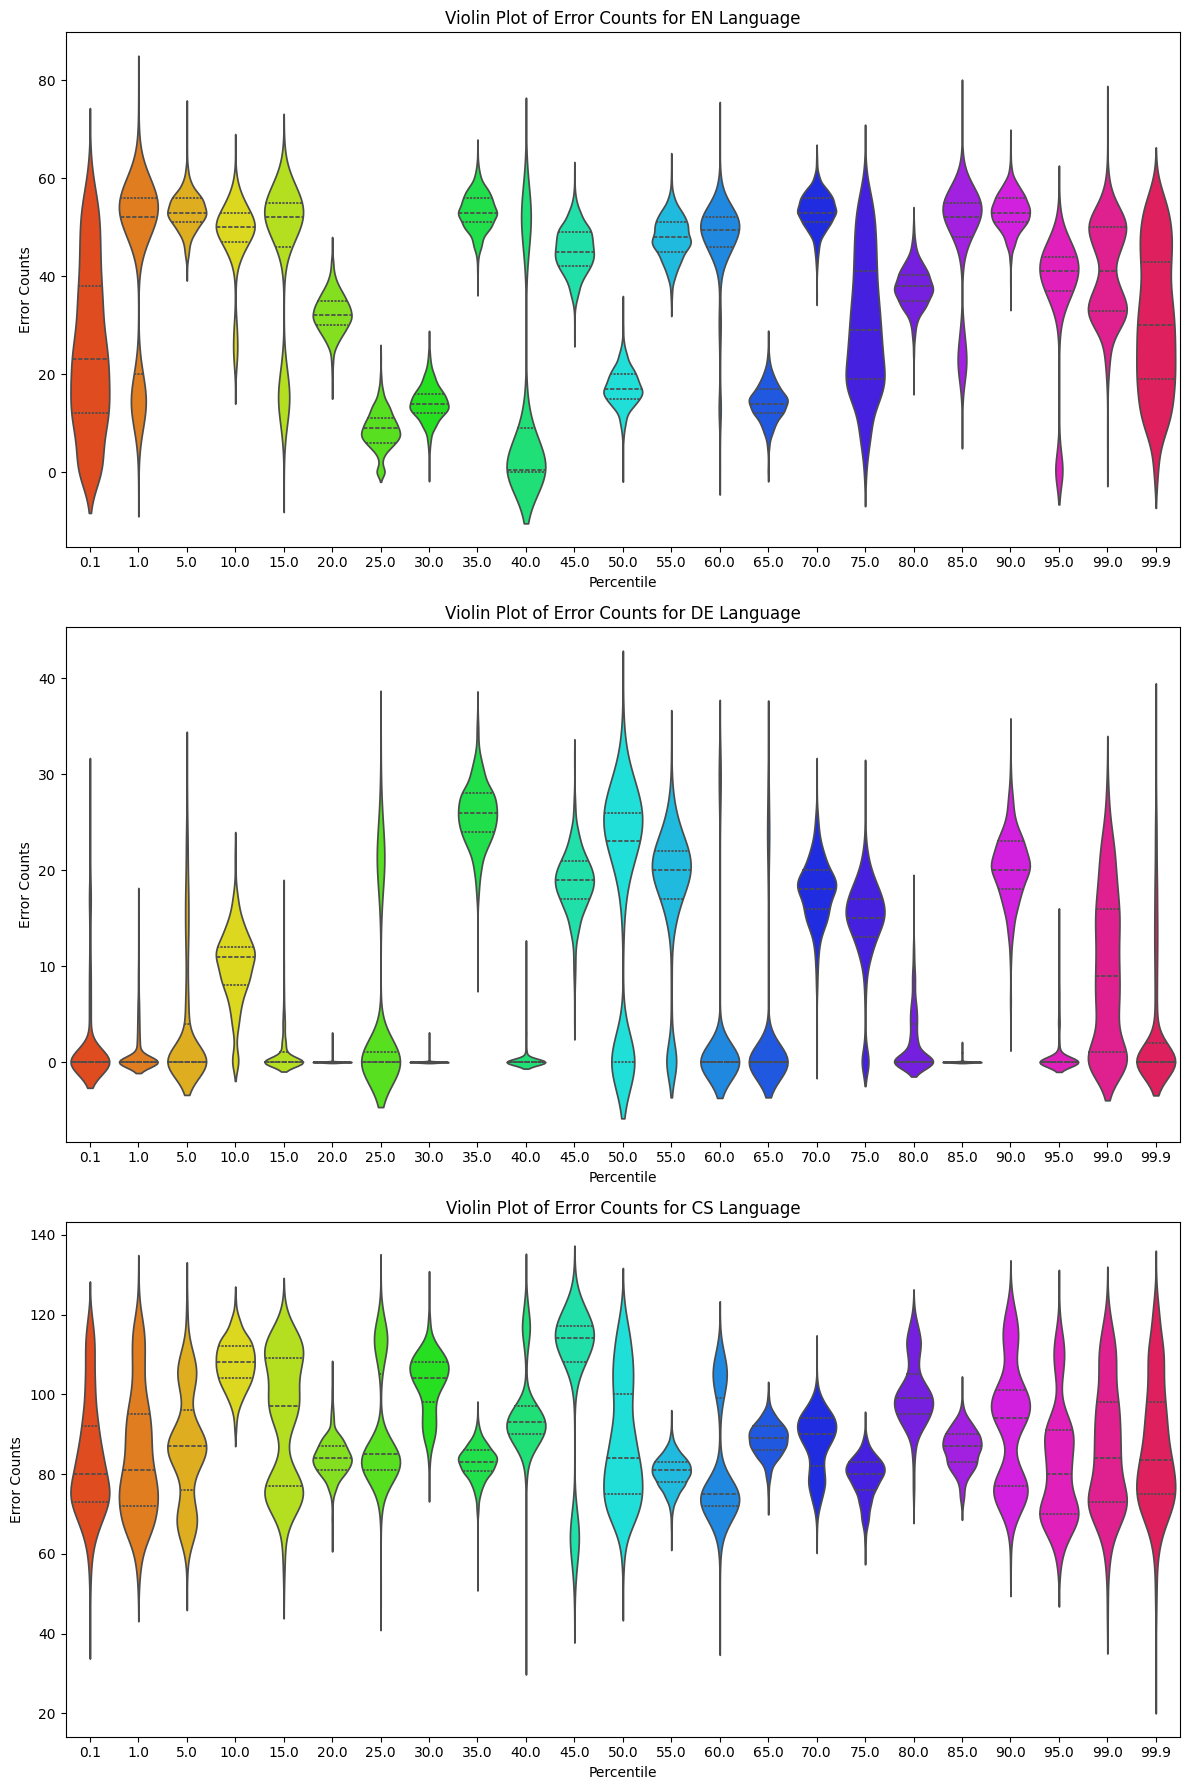

In [61]:
# - **eval_column: gpt2_tokens_per_char**
analyze_feature(all_data,'gpt2_tokens_per_char', languages)

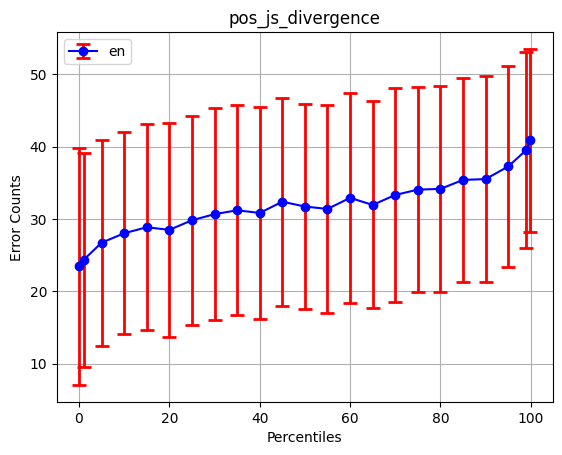

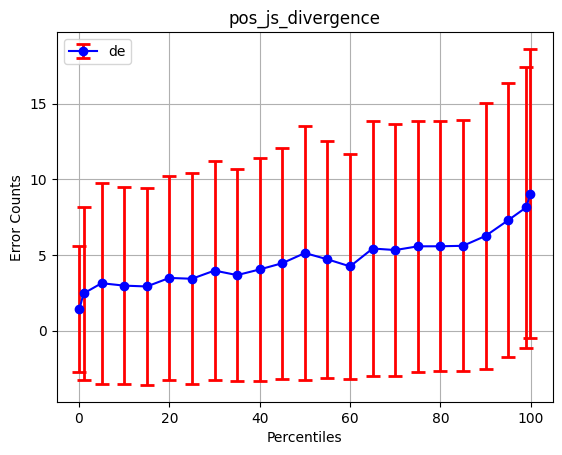

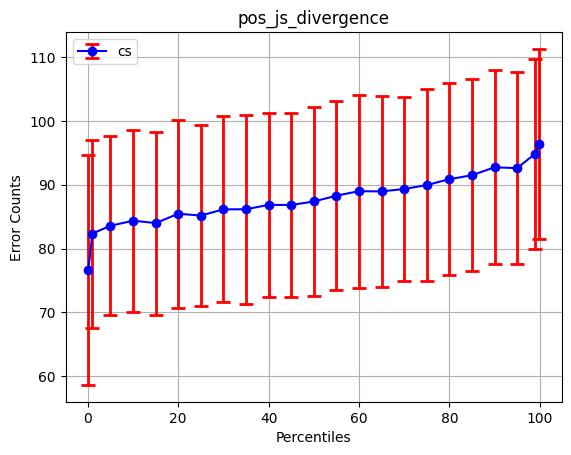

en pearson r for averages: 0.9530926839135988, en pearson r for medians: 0.9487705612583592
de pearson r for averages: 0.9389597529317795, de pearson r for medians: 0.5045253007094161
cs pearson r for averages: 0.9472566289342349, cs pearson r for medians: 0.9464495751787159


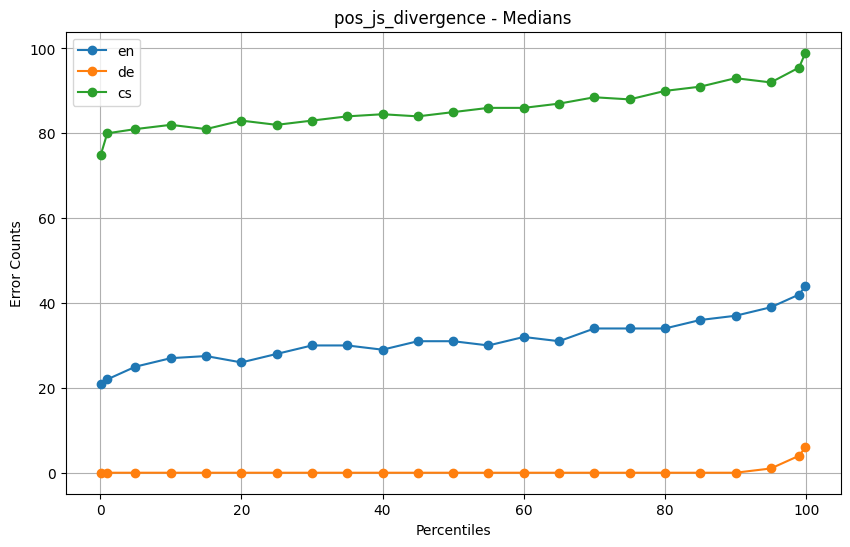

/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)


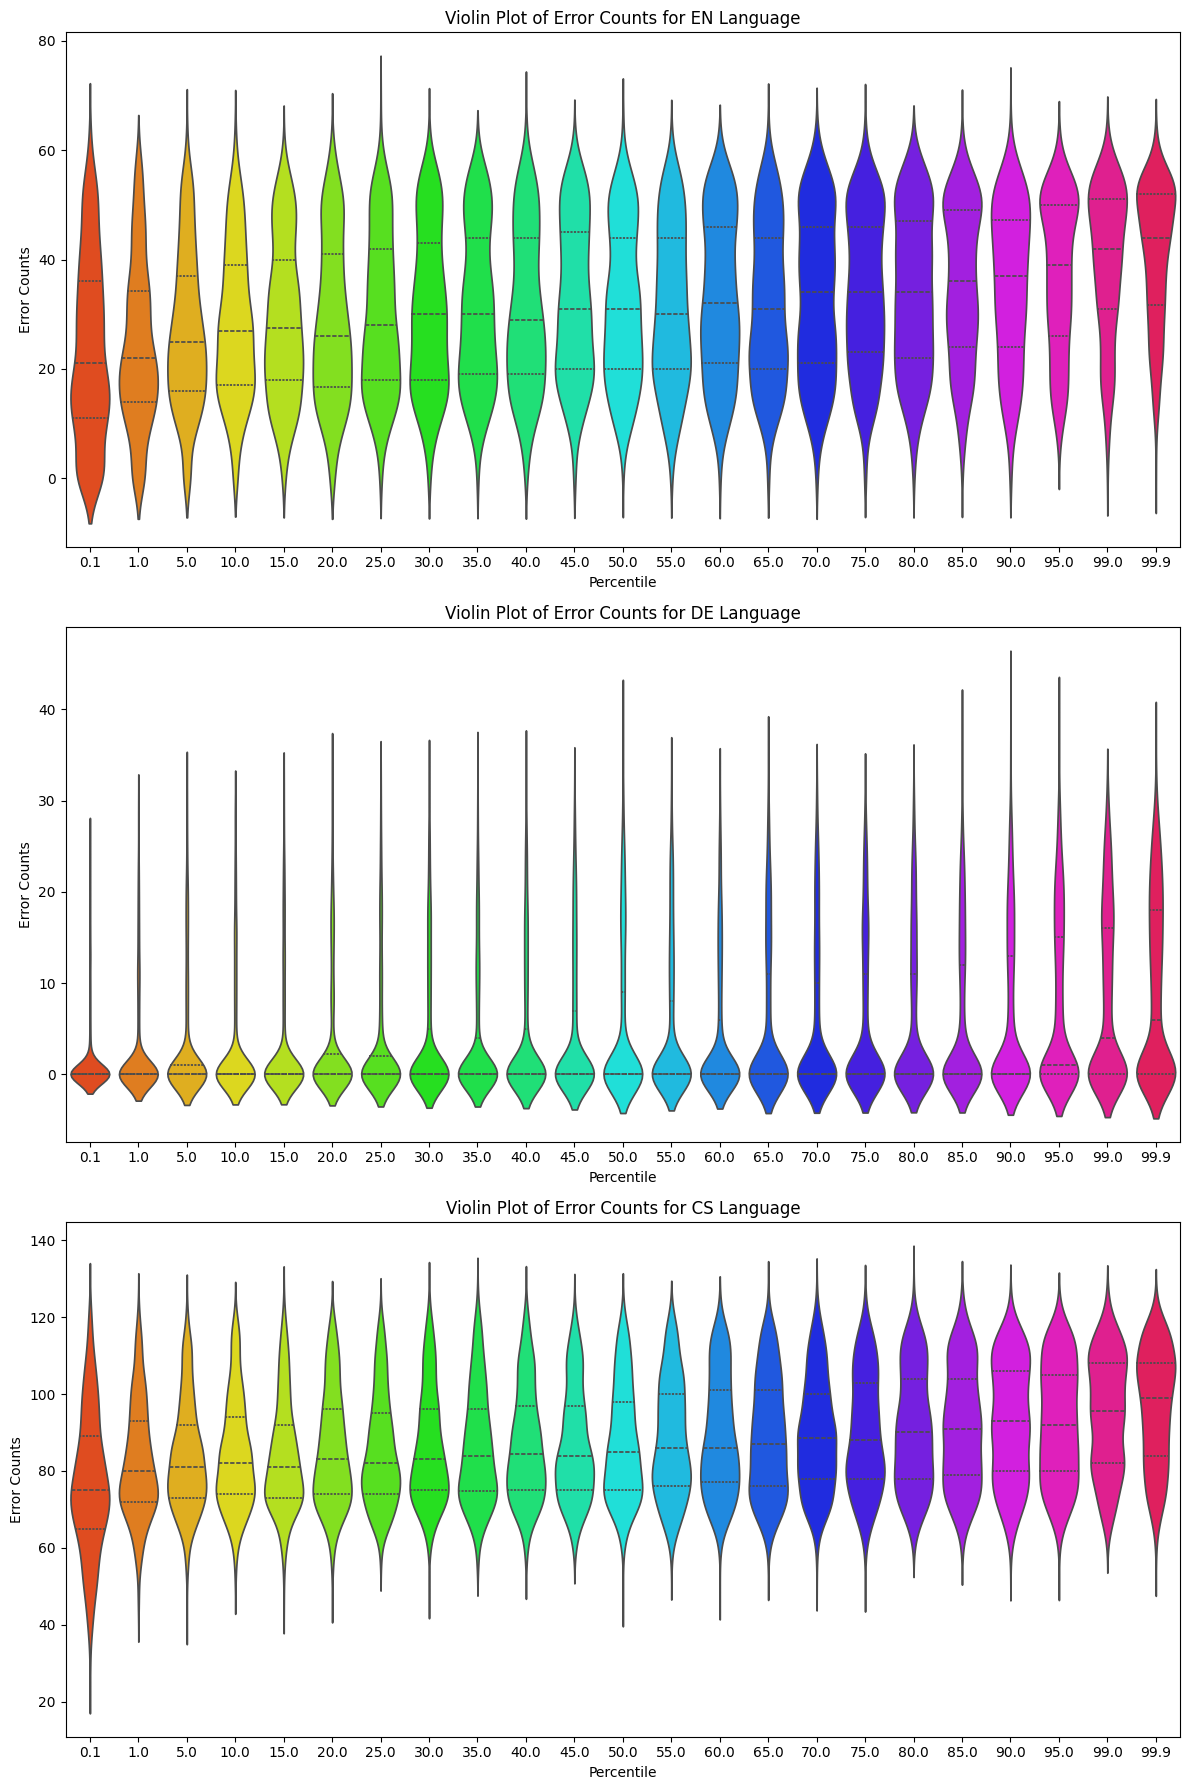

In [62]:

# - **pos_js_divergence**
analyze_feature(all_data,'pos_js_divergence', languages)

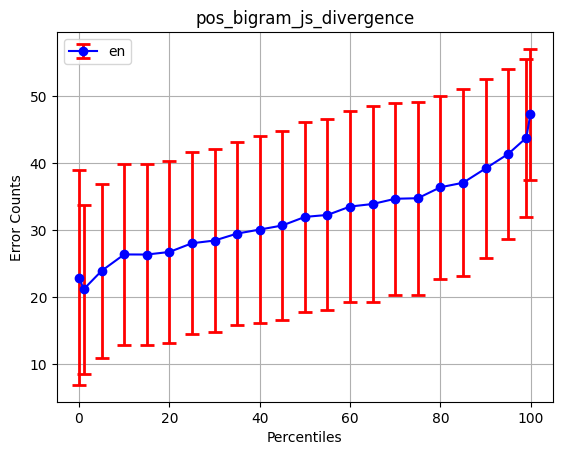

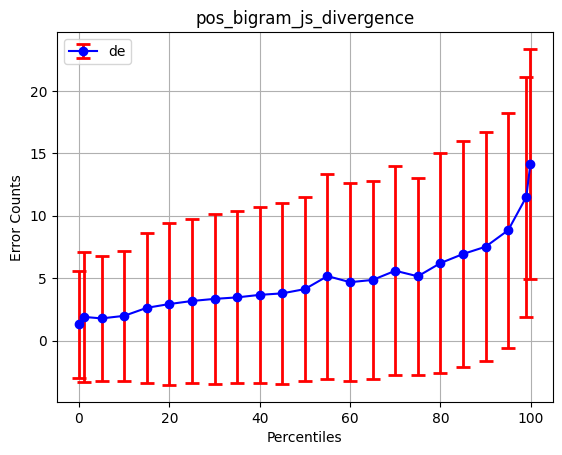

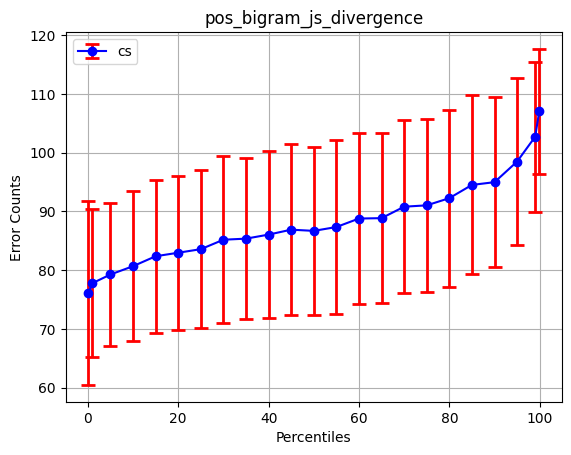

en pearson r for averages: 0.9693977605405151, en pearson r for medians: 0.9725515509851846
de pearson r for averages: 0.8884416931504153, de pearson r for medians: 0.55861820100822
cs pearson r for averages: 0.9497231772635227, cs pearson r for medians: 0.9418686594628325


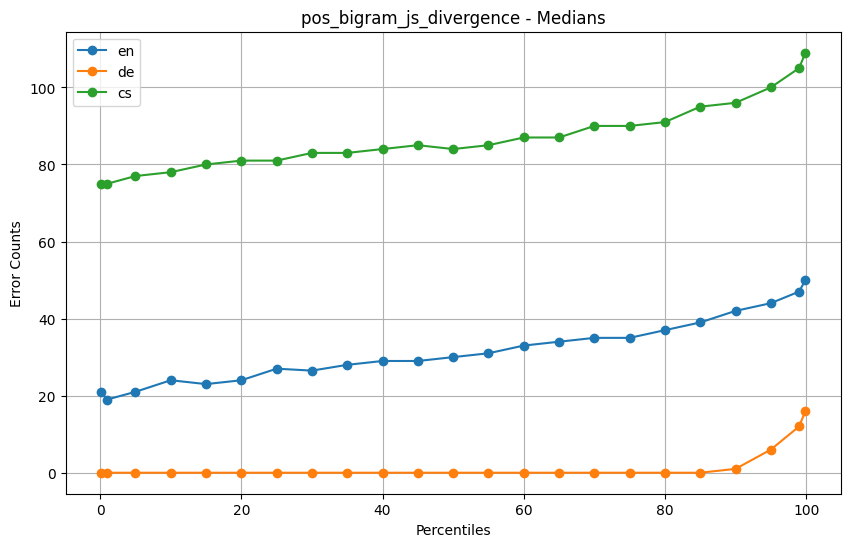

/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)


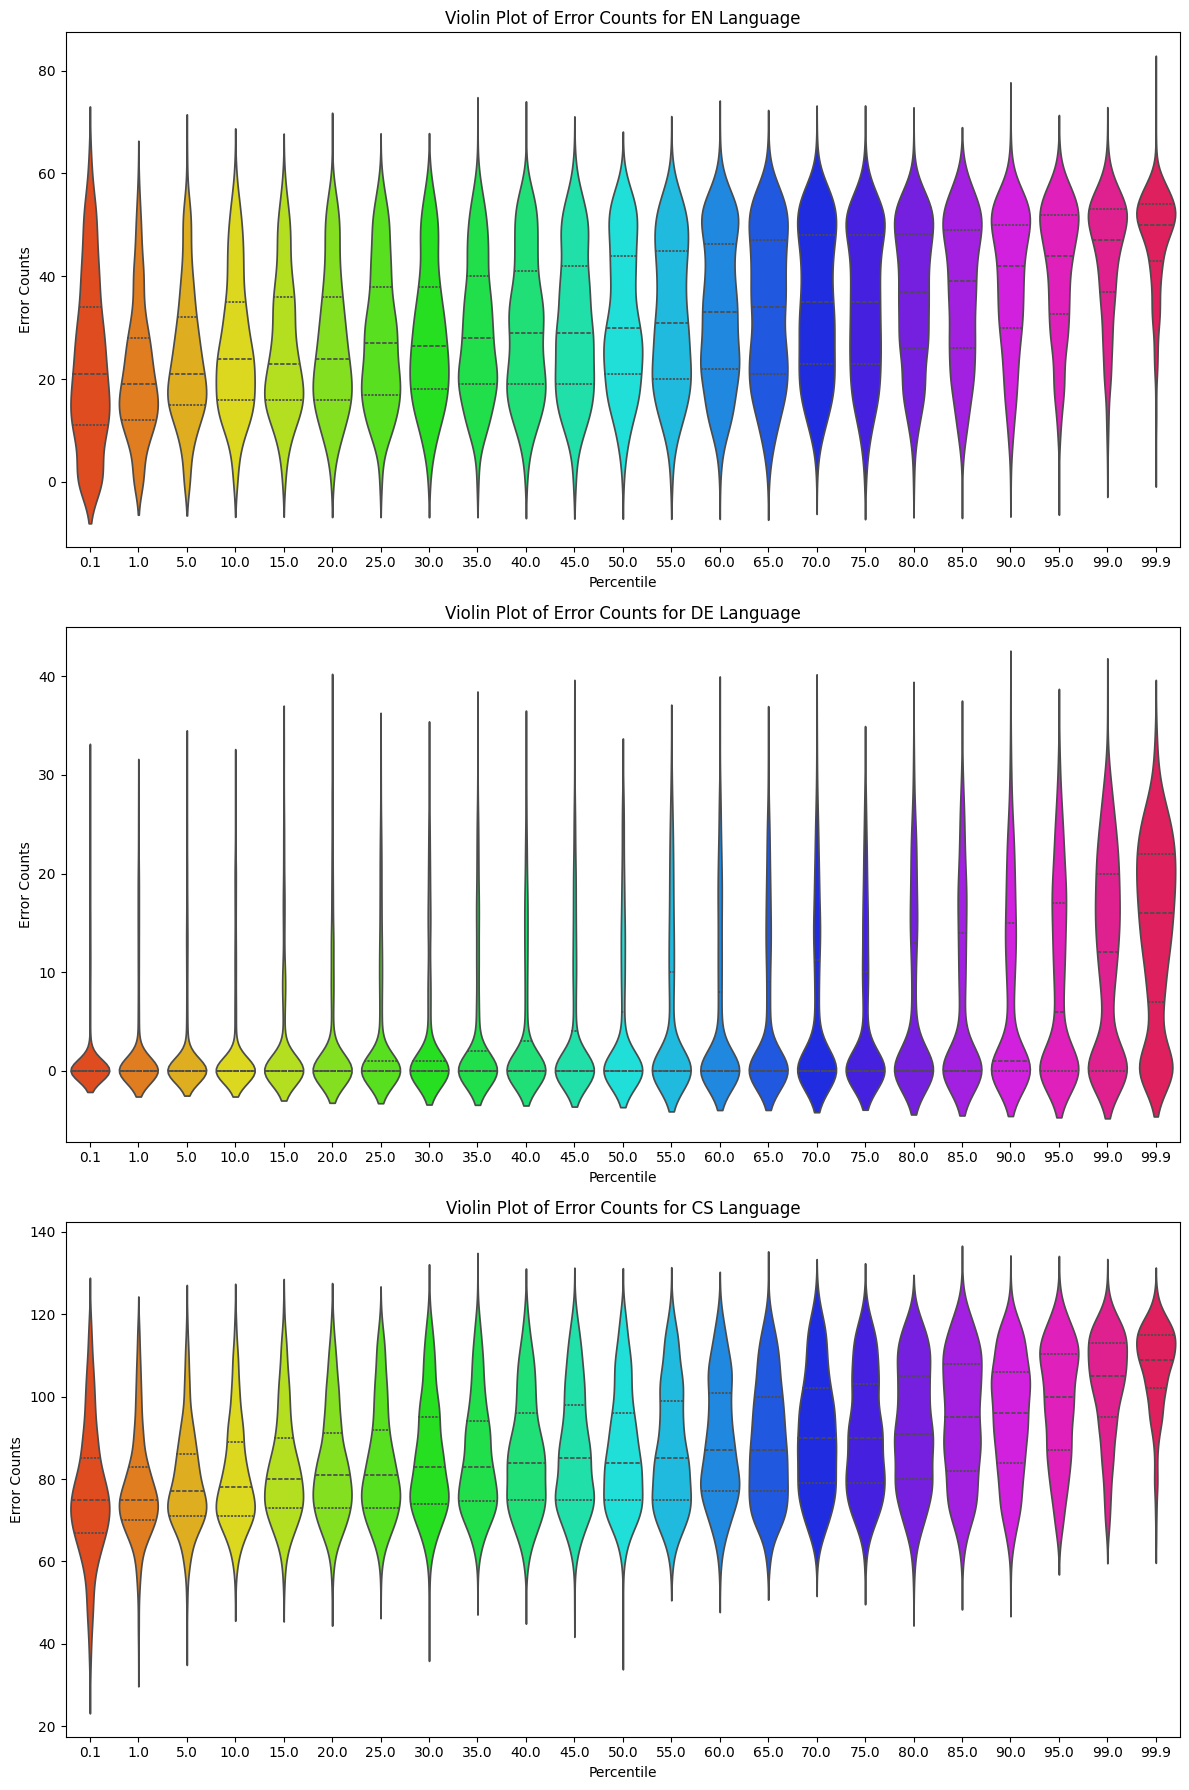

In [63]:

# - **pos_bigram_js_divergence**
analyze_feature(all_data,'pos_bigram_js_divergence', languages)

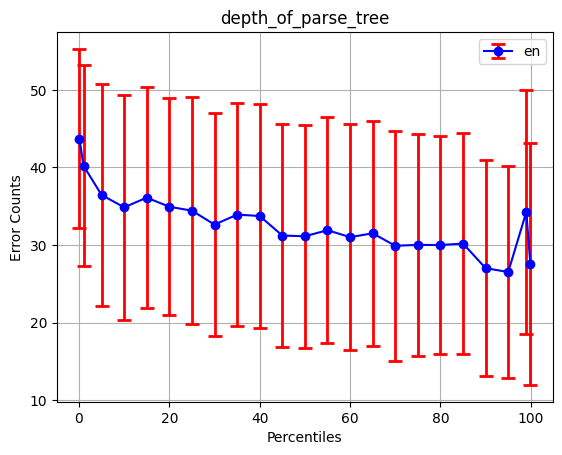

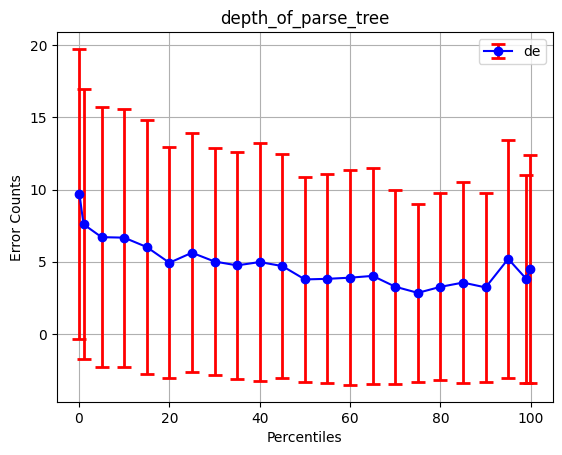

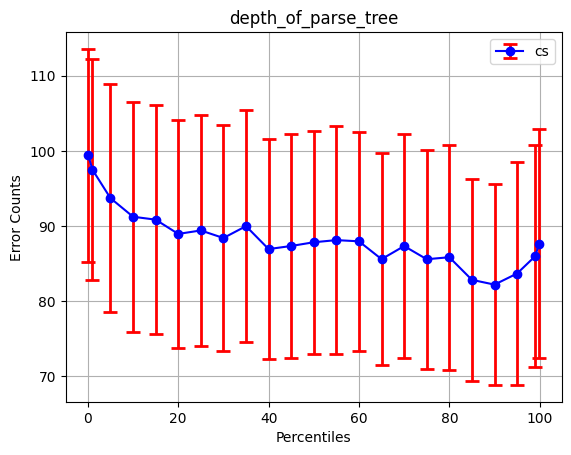

en pearson r for averages: -0.8336831773050737, en pearson r for medians: -0.8041718962182159
de pearson r for averages: -0.7752790970954208, de pearson r for medians: -0.37390749733501455
cs pearson r for averages: -0.8340228100314215, cs pearson r for medians: -0.8177137242130775


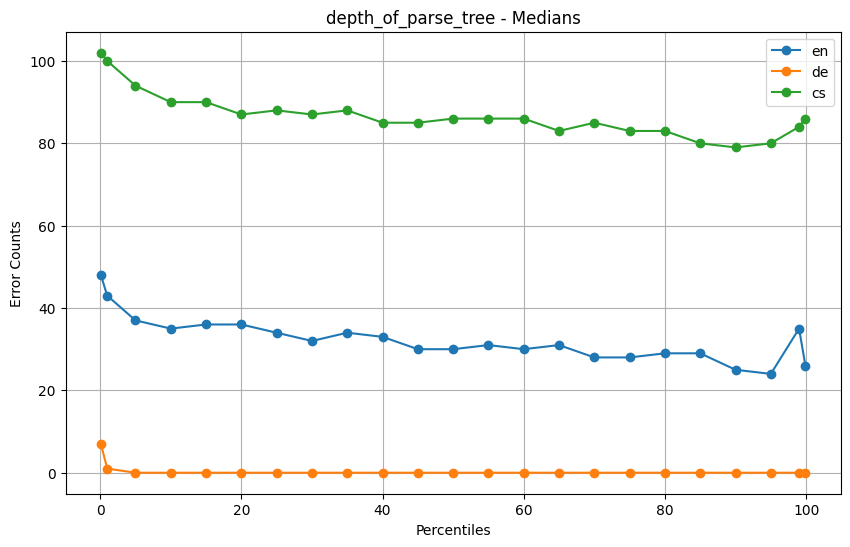

/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)


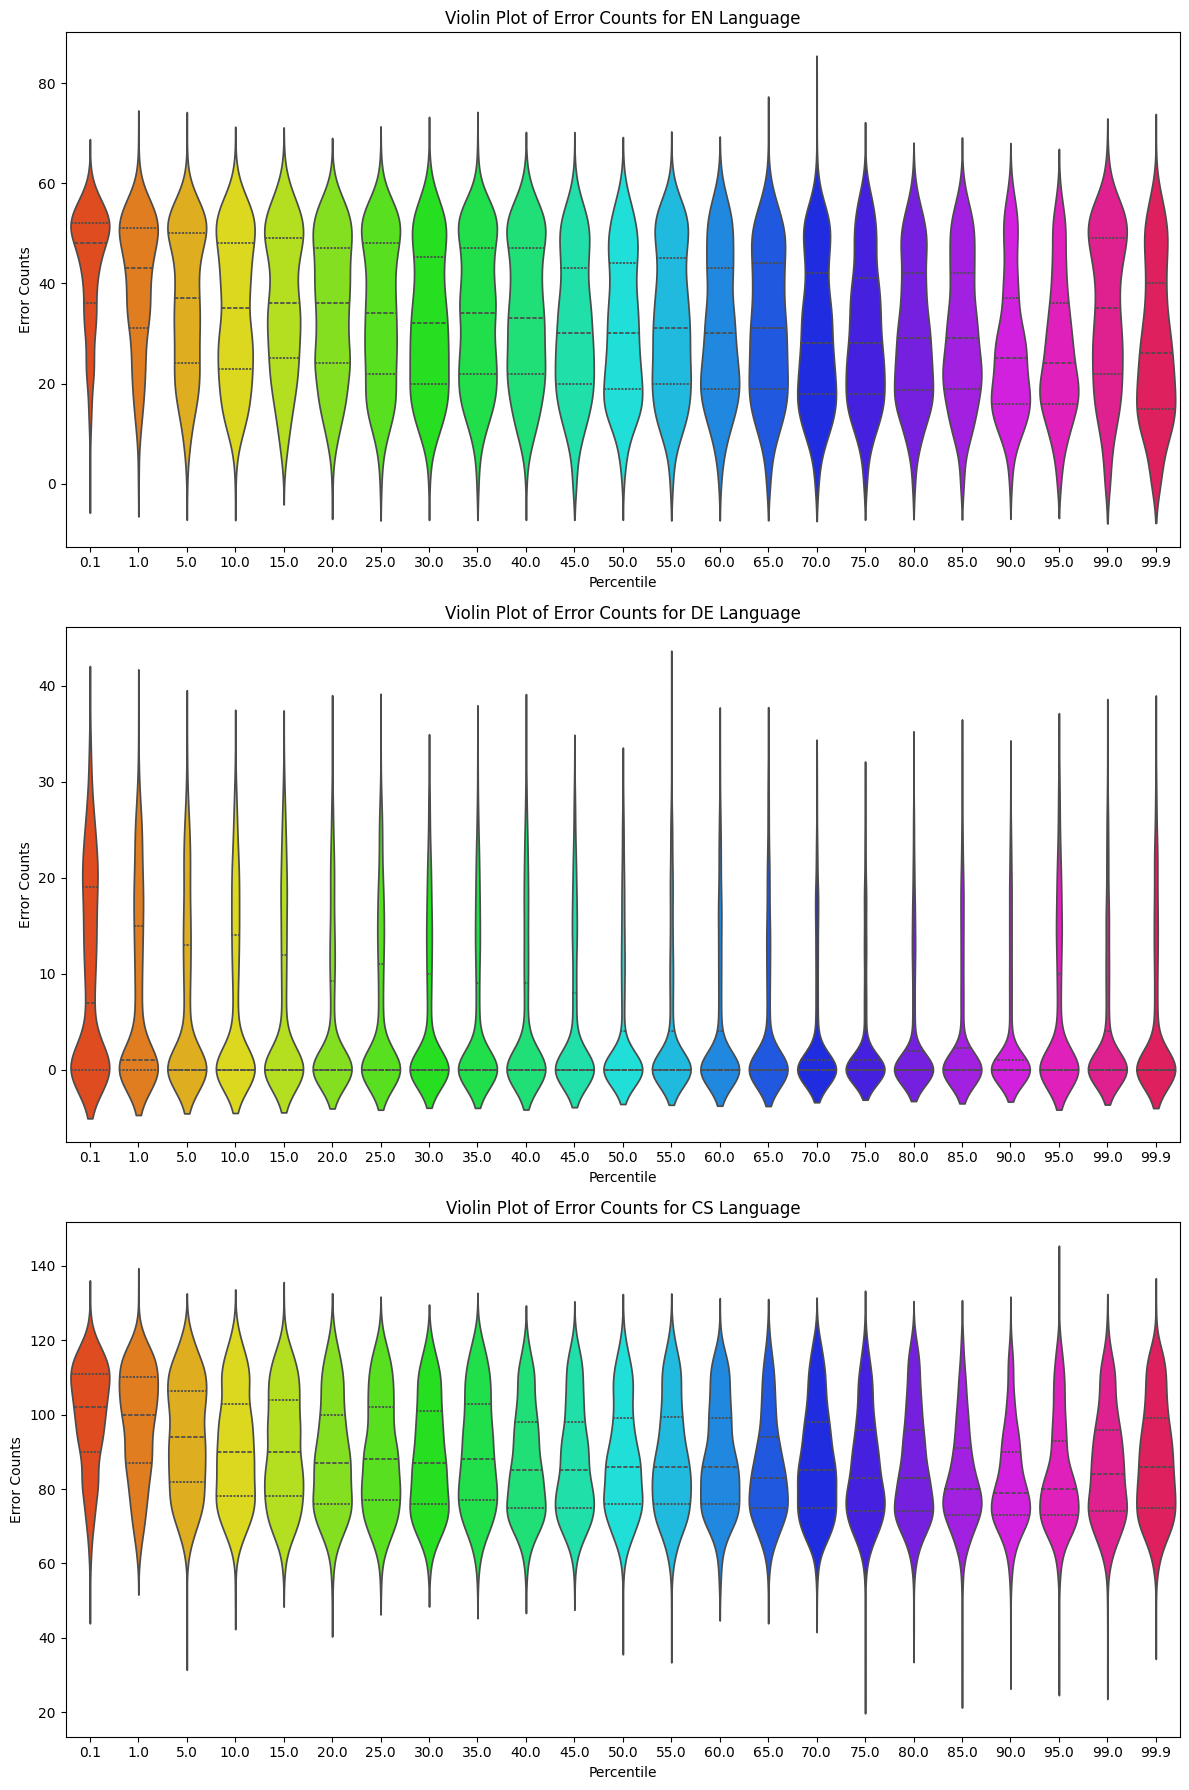

In [64]:

# - **depth_of_parse_tree**
analyze_feature(all_data,'depth_of_parse_tree', languages)

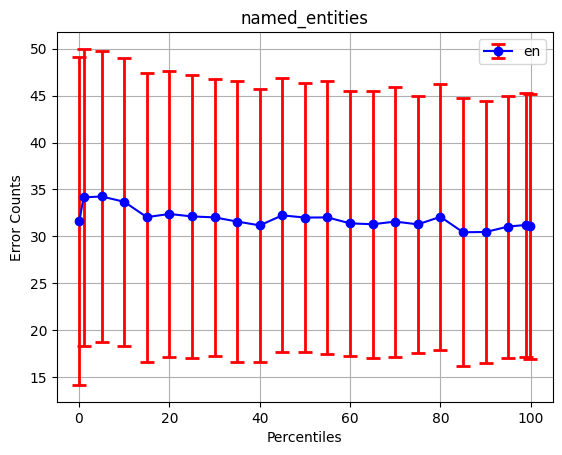

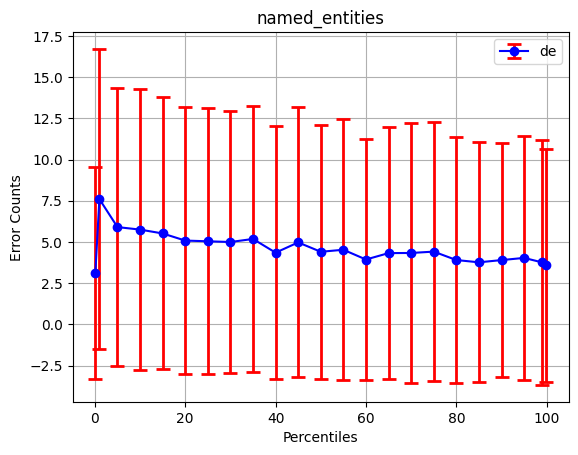

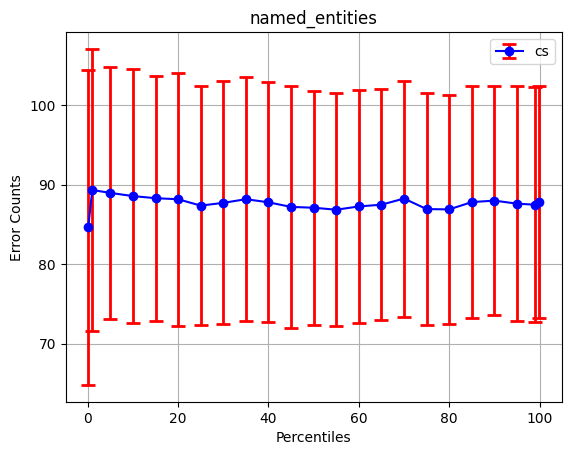

en pearson r for averages: -0.7441262277175716, en pearson r for medians: -0.8632580628823937
de pearson r for averages: -0.6635425208949182, de pearson r for medians: -0.3231867291431862
cs pearson r for averages: -0.13053252112185065, cs pearson r for medians: -0.5641511483158438


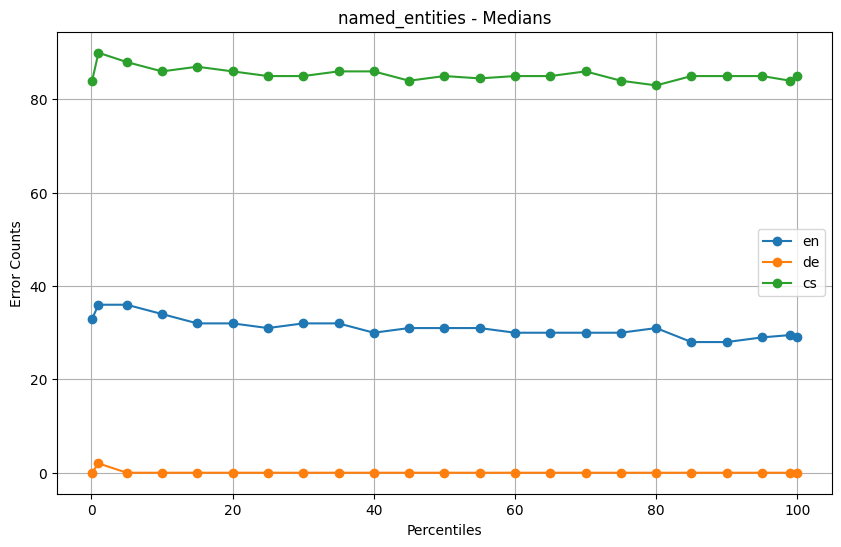

/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)
/tmp/ipykernel_75333/1624599555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Percentile', y='Error Count', data=df, inner='quartile', palette=palette)


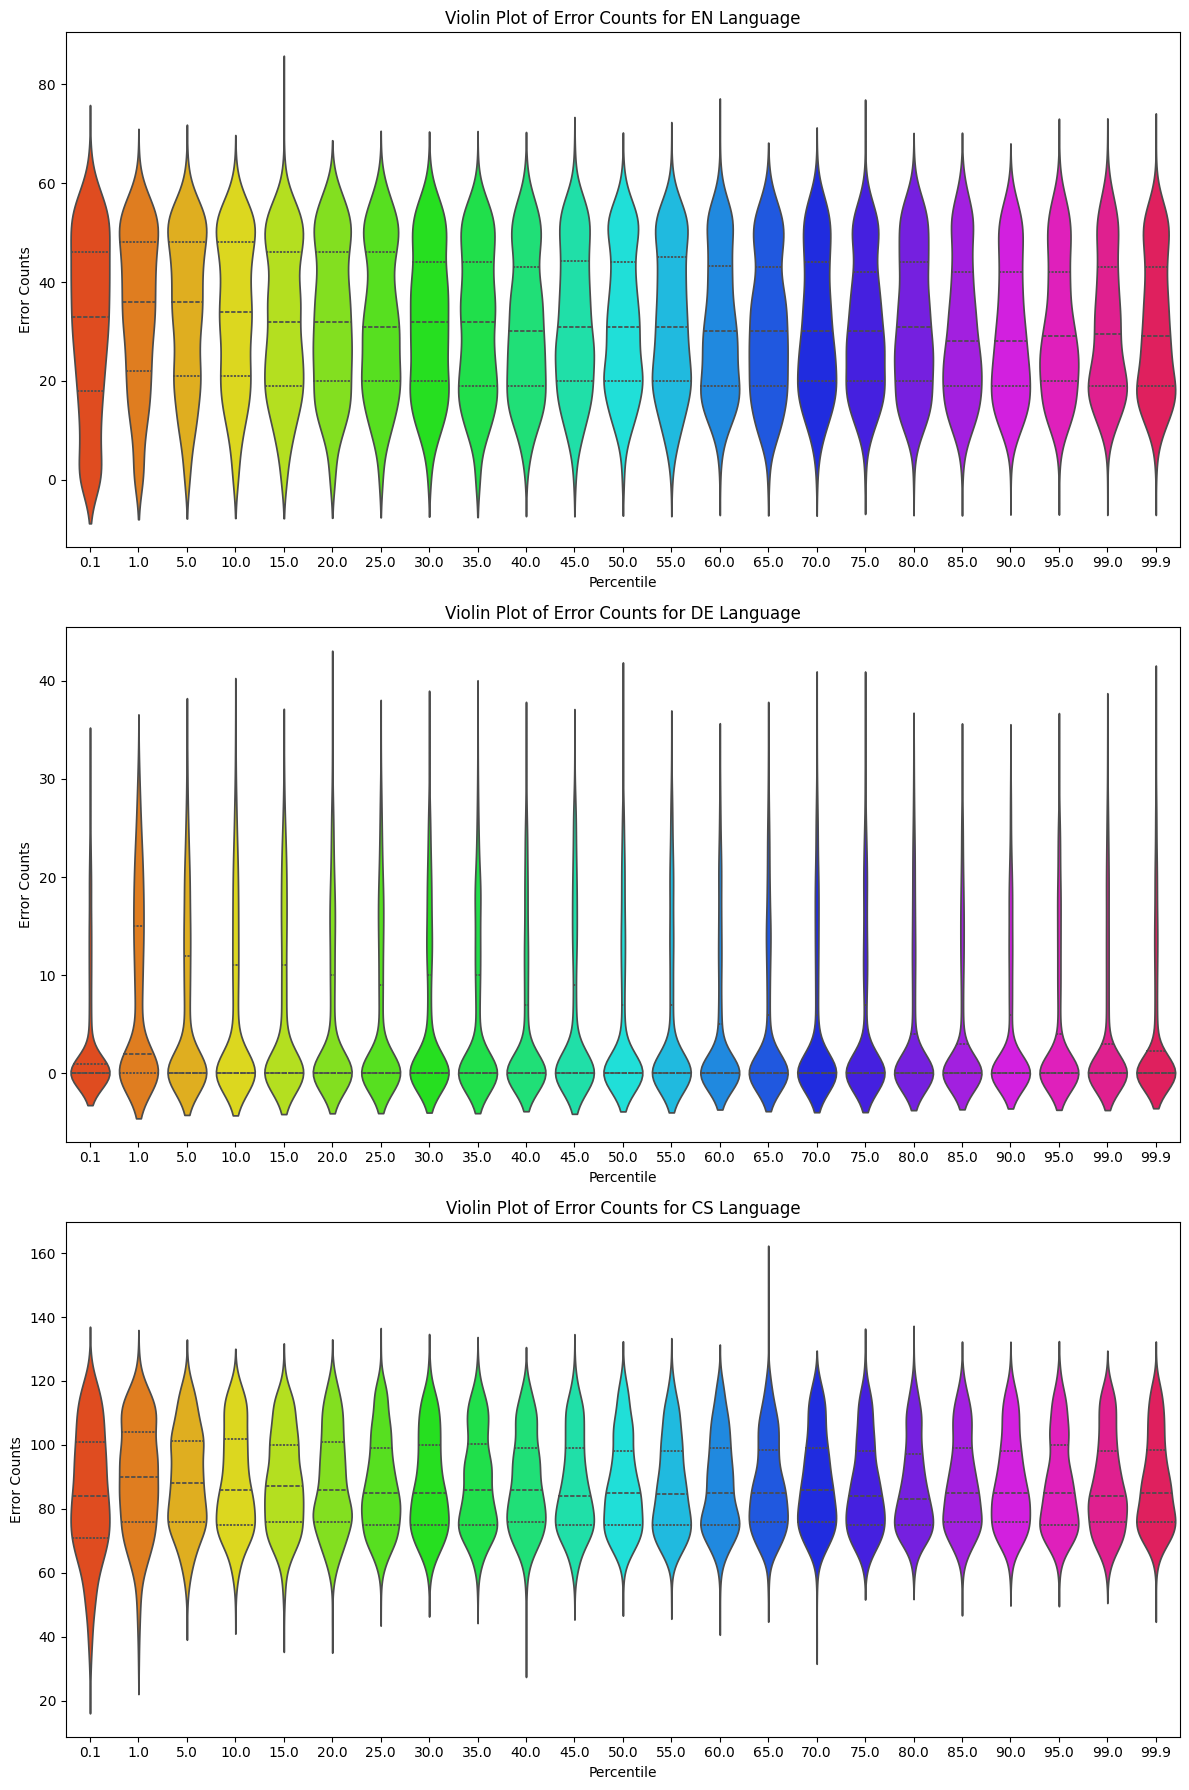

In [65]:

# - **named_entities**
analyze_feature(all_data,'named_entities', languages)

                          bigram_js_divergence  depth_of_parse_tree  \
bigram_js_divergence                  1.000000            -0.261430   
depth_of_parse_tree                  -0.261430             1.000000   
gpt2_perplexity                       0.211239            -0.132750   
gpt2_tokens_per_char                  0.440670            -0.124916   
named_entities                        0.095957            -0.056721   
pos_bigram_js_divergence              0.520431            -0.242211   
pos_js_divergence                     0.506454            -0.164187   
unigram_js_divergence                 0.661128            -0.170218   

                          gpt2_perplexity  gpt2_tokens_per_char  \
bigram_js_divergence             0.211239              0.440670   
depth_of_parse_tree             -0.132750             -0.124916   
gpt2_perplexity                  1.000000              0.173522   
gpt2_tokens_per_char             0.173522              1.000000   
named_entities           

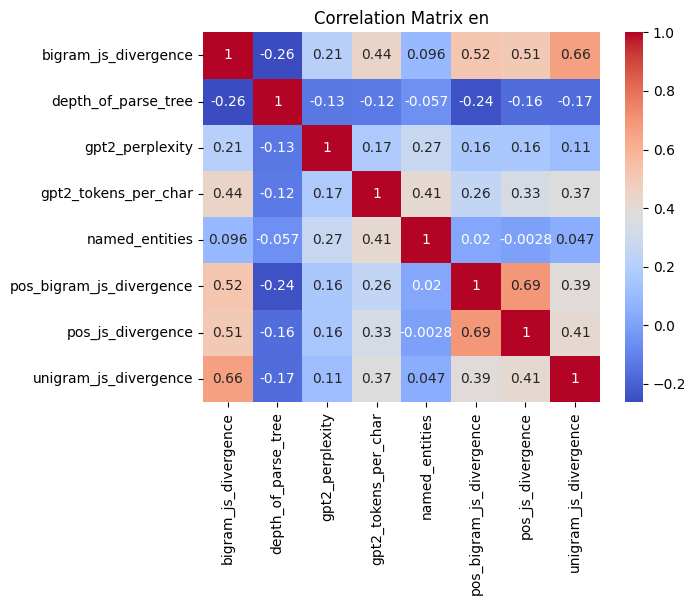

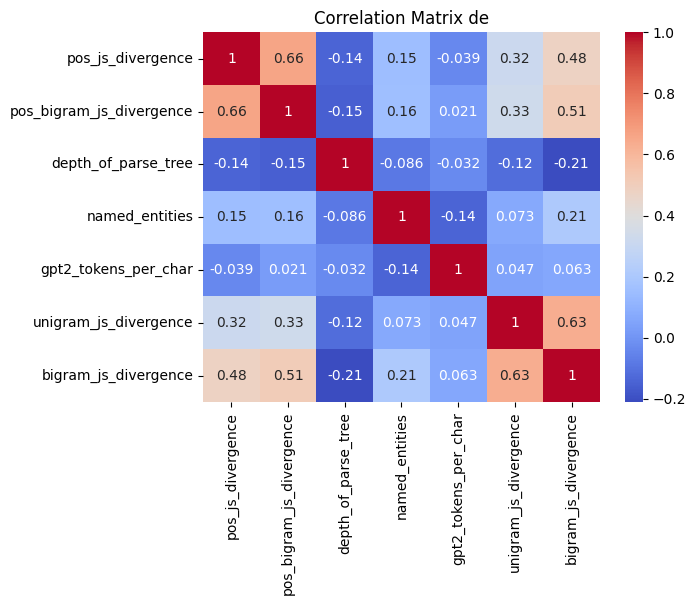

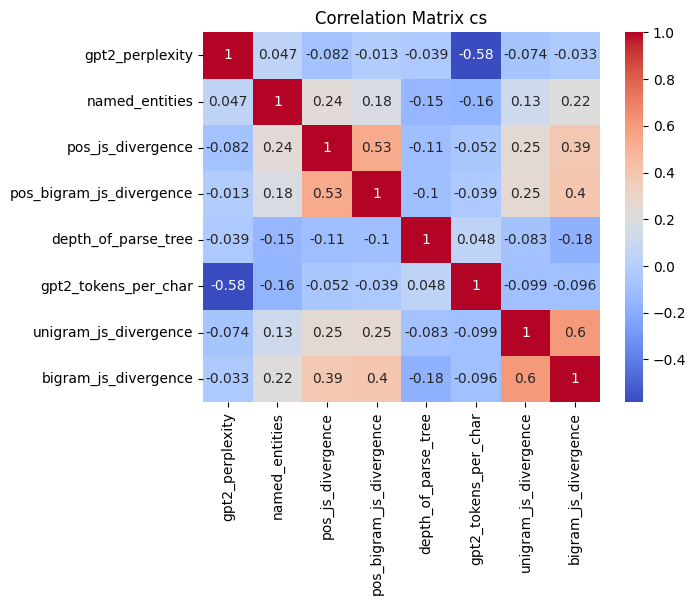

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

for lang in languages:
    # Step 1: Load the merged file
    df = pd.read_csv(f'news.2013.{lang}.trainlen.200.merged.csv')

    # Step 2: Drop non-numeric (text) columns
    numeric_df = df.select_dtypes(include=[np.number])

    # Step 3: Normalize columns if needed
    # Here, we'll use Z-score normalization
    scaler = StandardScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)

    # Step 4: Compute correlation matrix
    correlation_matrix = df_normalized.corr()
    print(correlation_matrix)

    # Step 5: Create a plot for the correlation matrix and save it
    plt.figure()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix {lang}')
    plt.savefig(f'corr{lang}.png')
    # print the corr matrix in text form:
    print(correlation_matrix.to_string())